In [2]:
%pip install numpy pandas statsmodels seaborn matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 KB 2.4 MB/s eta 0:00:000:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS

import yfinance as yf
import seaborn
import matplotlib.pyplot as plt

In [5]:
symbol_list = ['META', 'AMZN', 'AAPL', 'NFLX', 'GOOG']
data = yf.download(
    symbol_list, 
    start='2021-01-01', 
    end='2022-12-30'
)['Adj Close']

[*********************100%***********************]  5 of 5 completed


In [6]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [7]:
scores, pvalues, pairs = find_cointegrated_pairs(data)

/home/rachitt/.local/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/rachitt/.local/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


<AxesSubplot: >

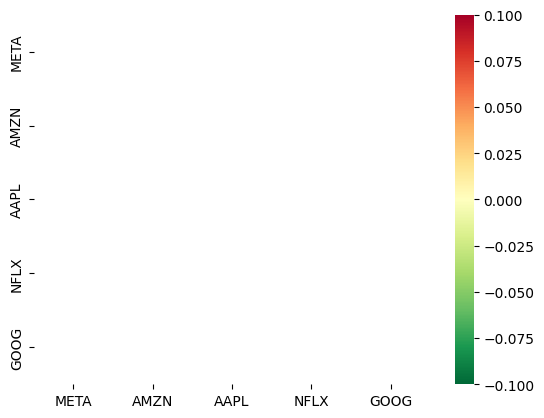

In [8]:
seaborn.heatmap(
    pvalues, 
    xticklabels=symbol_list, 
    yticklabels=symbol_list, 
    cmap='RdYlGn_r', 
    mask = (pvalues >= 0.05)
)

In [9]:
S1 = data.AMZN
S2 = data.AAPL

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1.AMZN
b = results.params['AMZN']
spread = S2 - b * S1

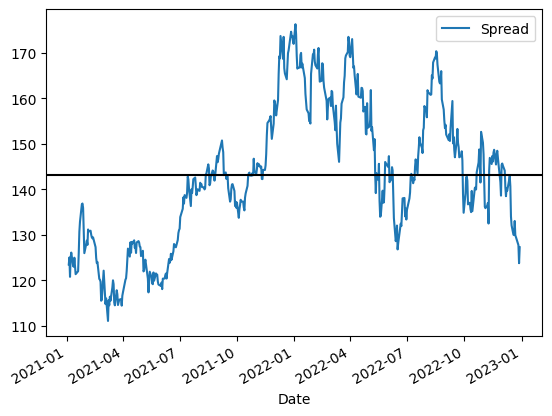

In [10]:
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

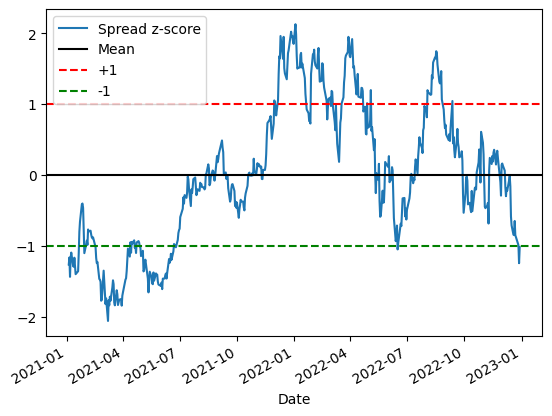

In [11]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

In [12]:
# Create a DataFrmae with the signal and position size in the pair
trades = pd.concat([zscore(spread), S2 - b * S1], axis=1)
trades.columns = ["signal", "position"]

# Add a long and short position at the z-score levels
trades["side"] = 0.0
trades.loc[trades.signal <= -1, "side"] = 1
trades.loc[trades.signal >= 1, "side"] = -1

<AxesSubplot: xlabel='Date'>

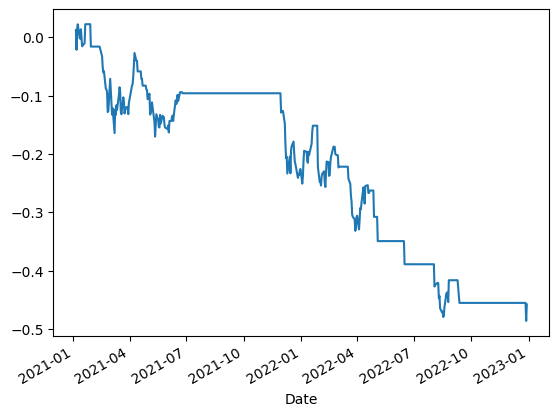

In [13]:
returns = trades.position.pct_change() * trades.side
returns.cumsum().plot()